# Settings

In [27]:
Grouping = 'Monat' # Alternativ Quartal
Sport = 'Running'
MIN_LAP_TRIM = 2
MAX_LAP_TRIM = 2

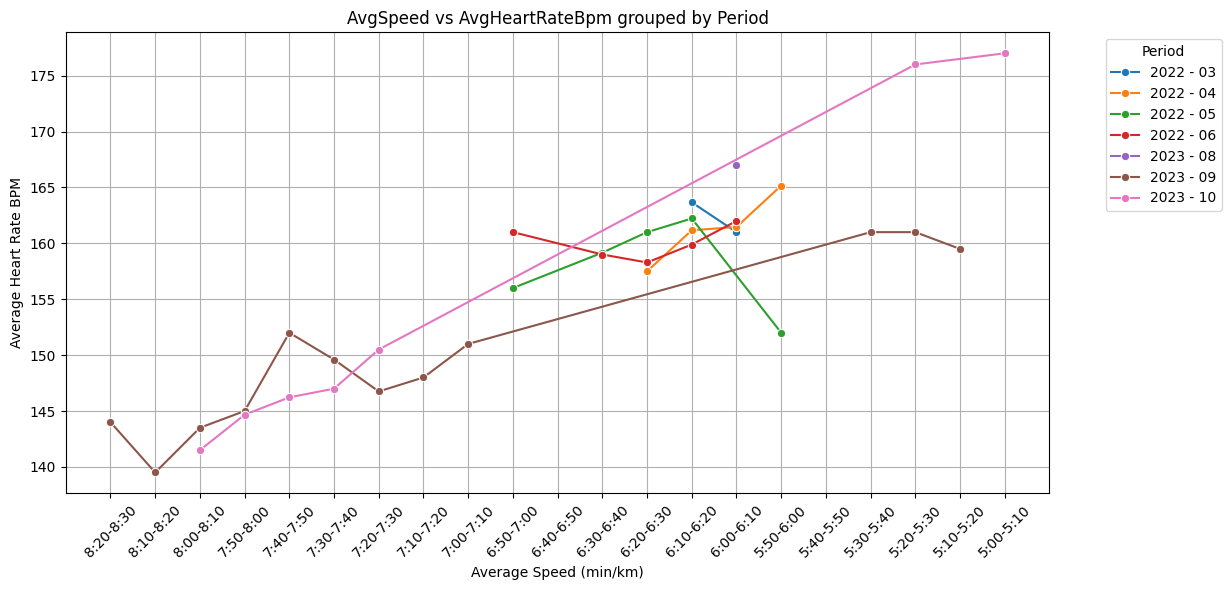

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from lxml import etree
import seaborn as sns
import io
import numpy as np
from datetime import datetime

def convert_to_min_sec(x):
    minutes = int(x)
    seconds = int((x - minutes) * 60)
    return f"{minutes}:{seconds:02d}"

def map_date_to_quarter(date_str):
    # Parse the date string
    date = datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S.%fZ") 
    # Determine the quarter
    if 1 <= date.month <= 3:
        quarter = "Q1"
    elif 4 <= date.month <= 6:
        quarter = "Q2"
    elif 7 <= date.month <= 9:
        quarter = "Q3"
    else:
        quarter = "Q4"
    # Return the formatted string
    return f"{date.year} - {quarter}"

def remove_first_n_and_last_m(arr, n_first, m_last):
    if len(arr) >= n_first + m_last:
        arr = arr[n_first:-m_last]
        return arr
    else:
        return []


namespaces = {
    'default': "http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2",
    'ns3': "http://www.garmin.com/xmlschemas/ActivityExtension/v2",
    # Add other namespaces here as needed
}

with open('merged.tcx', 'rb') as file:
    xml_data = file.read()
    root = etree.fromstring(xml_data)
    
data = []
for activity in root.findall(".//default:Activity", namespaces=namespaces):
    if activity.get('Sport') == Sport:
        laps = activity.findall(".//default:Lap", namespaces=namespaces)
        laps = remove_first_n_and_last_m(laps, MIN_LAP_TRIM, MAX_LAP_TRIM)
        for lap in laps:
            distance = float(lap.find("default:DistanceMeters", namespaces=namespaces).text)
            if distance >= 500:
                avg_heart_rate = int(lap.find(".//default:AverageHeartRateBpm/default:Value", namespaces=namespaces).text)
                max_heart_rate = int(lap.find(".//default:MaximumHeartRateBpm/default:Value", namespaces=namespaces).text)
                if abs(avg_heart_rate-max_heart_rate)<=8:
                    time = lap.get("StartTime")
                    if Grouping == 'Monat':
                        period = time.split("-")[0] + ' - ' + time.split("-")[1]  # Extracting month and year
                    elif Grouping == 'Quartal':
                        period = map_date_to_quarter(time)
                    avg_speed = lap.find(".//ns3:AvgSpeed", namespaces=namespaces).text
                    data.append((period, float(avg_speed), int(avg_heart_rate)))

# Convert data to DataFrame
df = pd.DataFrame(data, columns=["Period", "AvgSpeed", "AvgHeartRateBpm"])
df['AvgSpeed'] = (1/df['AvgSpeed']) * (1000/60)
bin_width = 10/60  # 5 seconds expressed in minutes
bin_edges = list(np.arange(df['AvgSpeed'].min(), df['AvgSpeed'].max() + bin_width, bin_width))

# Define bin labels: "0-0:05", "0:05-0:10", ... for indicating speed ranges
bin_labels = [f"{int(i)}:{int((i*60)%60):02d}-{int(i+bin_width)}:{int(((i+bin_width)*60)%60):02d}" for i in bin_edges[:-1]]

# Create a new column 'SpeedGroup' to categorize avg speed into bins
df['SpeedGroup'] = pd.cut(df['AvgSpeed'], bins=bin_edges, labels=bin_labels, right=False)

# Group by the new 'SpeedGroup' and Month, and calculate the mean of the heart rate for each group
grouped_df = df.groupby(['SpeedGroup', 'Period']).agg(AvgHeartRateBpm=('AvgHeartRateBpm', 'mean')).reset_index()

# Plotting
plt.figure(figsize=(30,6))
sns.lineplot(data=grouped_df, x='SpeedGroup', y='AvgHeartRateBpm', hue='Period', marker="o")

plt.title('AvgSpeed vs AvgHeartRateBpm grouped by Period')
plt.xlabel('Average Speed (min/km)')
plt.ylabel('Average Heart Rate BPM')
plt.legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')

# Optional: Invert x-axis if you prefer lower speeds on the right
plt.gca().invert_xaxis()
plt.gca().set_aspect(1/4) 
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()